# Autoencoder network: SDNE

In [41]:
import torch
import torch.nn as nn
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm
# from sklearn.manifold import TSNE
from openTSNE import TSNE  # faster implementation of sklearn TSNE
from sklearn.decomposition import PCA
from typing import List

%matplotlib inline

## Load the graph

The graph represents the mail sent between different users.

```
@inproceedings{nr,
    title={The Network Data Repository with Interactive Graph Analytics and Visualization},
    author={Ryan A. Rossi and Nesreen K. Ahmed},
    booktitle={AAAI},
    url={https://networkrepository.com},
    year={2015}
}
```

In [2]:
df = pd.read_csv("./email_eu/email-EU.edges", sep=" ", header=None)
df.columns = ["source", "target"]

In [3]:
G = nx.from_pandas_edgelist(df)

In [5]:
print("Edges: ", G.number_of_edges())
print("Nodes: ", G.number_of_nodes())
print("Density: ", nx.density(G))

Edges:  54397
Nodes:  32430
Density:  0.00010344855751524997


## SDNE

[Link](https://www.kdd.org/kdd2016/papers/files/rfp0191-wangAemb.pdf) to the paper.

Structural Deep Network Embedding is an autoencoder network that tries to jointly optimize first-order proximity (in a supervised way) and second-order proximity (unsupervised).

Training this model is quite problematic for the following reasons:

- we need the compute the forward pass on the whole adjacency matrix
- the model has a high non-linearity, with a complex and full-of-minima cost function
- the correctly implement the model, we need to pre-initialize the weight with a Deep Belief Network strategy
- working in batch mode requires a carefully devised sampling strategy

Furthermore, working with Torch sparse tensor is not optimal since many backpropagation functions aren't implemented yet.

All that said, this model isn't popular. 

In [7]:
class SDNE(nn.Module):
  """SDNE implementation. This model implements a stacked autoencoder
  network that tries to learn a low-dimensional
  representation of the network by optimizing the reconstruction
  of the adjacency matrix."""
  def __init__(
    self,
    graph: nx.classes.graph.Graph,
    n_latent: int,
    encoder_dims: List[int],
    decoder_dims: List[int],
  ):
    """Create a SDNE network
    
    Args:
    graph: nx.classes.graph.Graph
      the graph to learn the embedding of
    n_latent: int
      the dimension of the latent space
    encoder_dims: List[int]
      the dimensions of the encoder networks
    decoder_dims: List[int]
      the dimenstions of the decoder networks
    """
    super(SDNE, self).__init__()
    self.n_nodes = graph.number_of_nodes()
    self.n_latent = n_latent
    
    # Encoder
    _encoder = []
    encoder_dims = [self.n_nodes] + encoder_dims + [self.n_latent]
    for in_features, out_features in zip(encoder_dims, encoder_dims[1:]):
      _encoder.append(nn.Linear(in_features, out_features))
      _encoder.append(nn.Sigmoid())
    self.encoder = nn.Sequential(*_encoder)
    
    # Decoder
    _decoder = []
    decoder_dims = [self.n_latent] + decoder_dims + [self.n_nodes]
    for in_features, out_features in zip(decoder_dims, decoder_dims[1:]):
      _decoder.append(nn.Linear(in_features, out_features))
      _decoder.append(nn.Sigmoid())
    self.decoder = nn.Sequential(*_decoder)
      
  def forward(self, x):
    """Forward pass of the SDNE model.
    
    Args:
    x:
      batch input to perform the forward pass on
    
    Returns:
    x_h, z
      The reconstructed input and its latent space representation
    """
    z = self.encoder(x)
    x_h = self.decoder(z)
    return x_h, z
  
  def embed(self, x):
    """Embed the input vector.

    Args:
    x
      the vectors to embed
      
    Returns:
    the latent space representation of the input
    """
    with torch.no_grad():
      return self.encoder(x)

In [8]:
# Adjacency (sparse) matrix
adj = nx.adjacency_matrix(G)

## Create the model and the optimizer

In [34]:
sdne = SDNE(
  G,
  20,
  [1000],
  [1000],
)
optimizer = torch.optim.SGD(
  sdne.parameters(),
  lr=0.01,
  weight_decay=0.3,
  momentum=0.9,
)
scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  3,
  0.01,
)

## Training loop

In [37]:
beta = 3  # Parameter to weight positive links

epochs = 10
batch_size = 512
loss_count = 0
running_loss = 0
last_loss = torch.nan

nodes = G.number_of_nodes()

for epoch in trange(epochs, desc="epoch", leave=False):
  # Randomly sample nodes per batch. This is a biased sampling, since
  # we select batches of potentionally not connected nodes. Thus,
  # we optimize invalid region of the graphs. Finding a suitable
  # sampling strategy will lead to more stable and coherent results.
  perm = torch.randperm(nodes)
  for batch_number, idx in enumerate(trange(
    0,
    nodes,
    batch_size,
    desc="Batch",
    leave=False,
  ), start=1):
    end = min(nodes, idx+batch_size)
    batch_idx = perm[idx:end]
    batch_x = torch.tensor(adj[batch_idx].todense(), dtype=torch.float32)
    # Weight to favor positive links during backpropagation
    B = batch_x * (beta - 1) + 1

    x_h, z = sdne(batch_x)

    # Loss function: jointly optimize first-order proximity (loss2) and
    # second-order proximity (loss1)
    loss1 = torch.norm((x_h - batch_x) * B) ** 2
    # Note: we multiply by the adjacent matrix to optimize only connected
    # nodes.
    loss2 = (batch_x[:, batch_idx] * torch.cdist(z, z) ** 2).sum()
    loss = loss1 + 2 * loss2
    
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  running_loss /= batch_number
  # Early stopping
  if running_loss >= last_loss:
    loss_count += 1
    if loss_count == 3:
      print("early stopping...")
      break
  else:
    loss_count = 0
  last_loss = running_loss

  scheduler.step()
  print(f"[{epoch:3}] loss: {running_loss}")

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/64 [00:00<?, ?it/s]

[  0] loss: 383022.7451171875


Batch:   0%|          | 0/64 [00:00<?, ?it/s]

[  1] loss: 331042.2103729248


Batch:   0%|          | 0/64 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Plots

In [30]:
pca = PCA(n_components=2)
tsne = TSNE(perplexity=50)

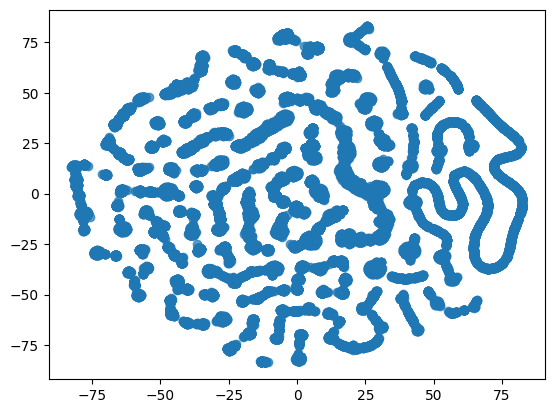

In [38]:
z = sdne.embed(torch.tensor(adj.todense(), dtype=torch.float32))

fig, ax = plt.subplots()

tsne = TSNE(perplexity=30, n_jobs=8)
out = tsne.fit(z)
ax.scatter(
  out[:, 0],
  out[:, 1],
#   s=[x[1] for x in G.degree],
  alpha=0.7,
);